## 준비 작업
우선 필요한 라이브러리를 불러오고 자료를 받아옵니다.

In [1]:
# ln -s ~/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data

In [2]:
# Loading packages
import os
from os.path import join
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler 
from scipy import stats 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import missingno as msno


# 학습에 필요한 라이브러리들
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 하이퍼 파라미터 탐색(그리드)
from sklearn.model_selection import GridSearchCV

# 모델 변수에 담기
random_state = 2022                                    # 고정값  

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

# models = [gboost, xgboost, lightgbm, rdforest]
models = [lightgbm, xgboost]

# LMS 파일경로
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')            # 테스트, 즉 submission 시 사용할 데이터 경로

# 데이터 불러오기
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# 데이터의 shape 확인
print('train data dim : {}'.format(df_train.shape))
print('sub data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [3]:
6468/(6468+15035)

0.30079523787378504

## 함수 정의

In [4]:
# RMSE 구하기
def rmse2(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 두 변수 사이의 corr_coef 를 출력하고, 상관도를 그리는 함수
def corr_plot(x1,y1):
    data = pd.concat([df_train[x1], df2_train[y1]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.regplot(x=x1, y=y1, data=data)
    print('corr_coef of {} and {} ='.format(x1,y1), '{:0.4f}'.format(np.corrcoef(df_train[x1], df2_train[y1])[0,1]))
    
# z score 정규화
def zs_normal(lst):
    normalized = []
    mean = np.mean(lst)
    std = np.std(lst)
    for value in lst:
        normalized_num = (value - mean) / std
        normalized.append(normalized_num)
    return normalized

# 학습 결과 출력
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.30079523787378504)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

print('ok')

# Grid Search
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, 
                              param_grid=param_grid, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              verbose=verbose, 
                              n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

ok


## 결측치 확인


In [5]:
# data = pd.concat((df_train, df_test), axis=0)
# msno.matrix(data)

다행히 결측치는 없습니다.

## 데이터 전처리

'date'칼럼을 int로 바꾸고 'id' 칼럼을 지우도록 하겠습니다.

In [6]:
try:
    # 'date' 칼럼 바꾸기
    df_train['date'] = df_train['date'].str[:8].astype(int)
    df_test['date'] = df_test['date'].str[:8].astype(int)


    # id 칼럼 지우기
    df_train = df_train.drop('id', axis=1)
    df_test = df_test.drop('id', axis=1)

    print('ok')

except:
    print('pass')



ok


간단히 각 칼럼별 상관관계를 살펴보겠습니다.

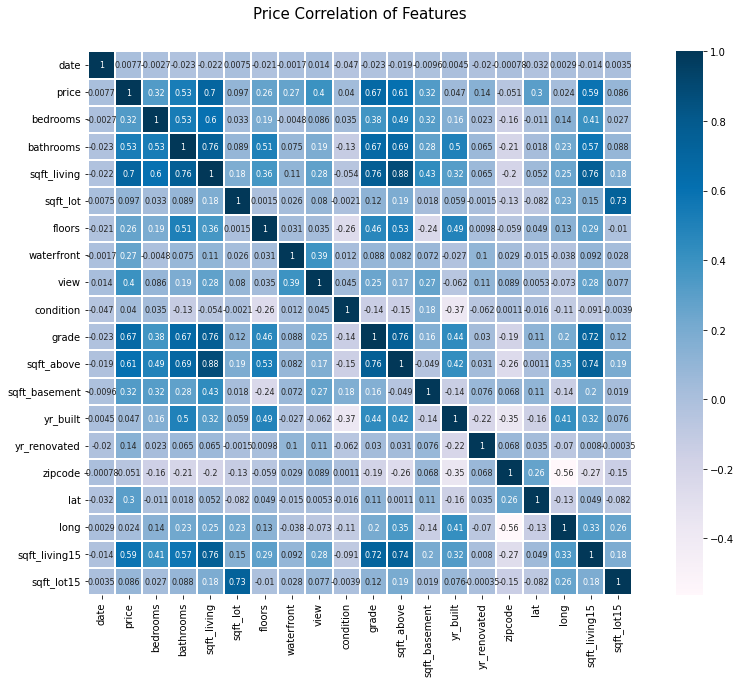

In [7]:
colormap = plt.cm.PuBu
plt.figure(figsize=(16, 10))
plt.title("Price Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df_train.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 8})
plt.show()

부동산 가격과 가장 상관관계가 높은 항목은 집의 크기, 집의 등급, 주변 집의 평균 크기 등입니다.  
나머지 항목도 부동산 가격과 연관이 있기에 통계상 측정하는 것일텐데 직접적인 상관관계는 없는 것으로 보입니다.   
이는 몇 가지 항목의 조합을 통해 상관도가 높은 다른 항목을 만드는 작업이 필요할 것으로 보입니다.  
    
우선 부동산의 위치를 확인해 보겠습니다.

Text(0.5, 0.98, 'Longitude and Latitude Distribution of df_test')

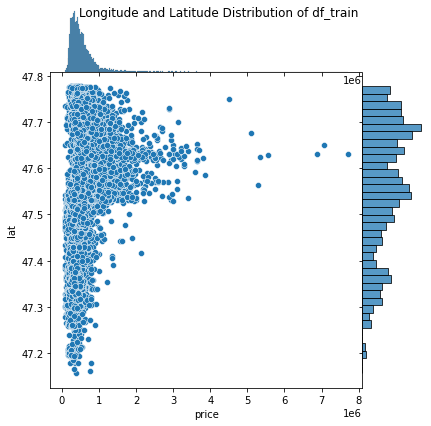

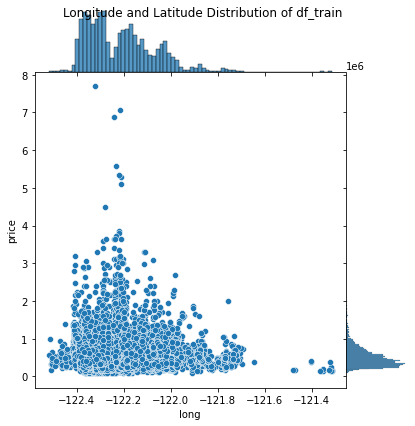

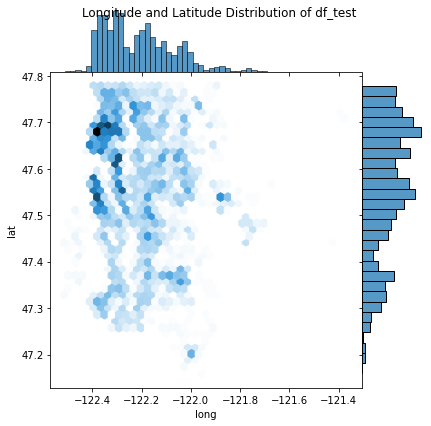

In [8]:
# 부동산 위치의 분포

sns.jointplot(x=df_train['price'], y=df_train['lat'], data=df_train, kind="scatter", space=0)
plt.suptitle("Longitude and Latitude Distribution of df_train")

sns.jointplot(x=df_train['long'], y=df_train['price'], data=df_train, kind="scatter", space=0)
plt.suptitle("Longitude and Latitude Distribution of df_train")

sns.jointplot(x=df_test['long'],y=df_test['lat'],data=df_test,kind="hex", space=0)
plt.suptitle("Longitude and Latitude Distribution of df_test")


첫번째 그림은 위도(lat.)와 가격 사이의 그래프입니다. 위도 47.6~ 47.7에 가장 몰려있고 최고값이 있습니다. 
두번째 그림은 경도(long.)와 가격 사이의 그래프입니다. 경도 -122.4~ -122.2에 가장 몰려있고 최고값이 있습니다.   
세번째 그림도 가격이 가장 높은 곳 주변에서 거래가 활발히 일어나는 것을 볼 수 있습니다(heatmap).  
    
이를 통해 위도 47.6 경도 -122.3 근방이 이 지역의 중심지일 가능성이 높고 부동산의 가격도 높게 형성돼 있을 것으로 보입니다.

### 정규화

(LMS 노드를 통해)label인 price값이 한쪽으로 쏠려 있음을 알았으므로 정규화 하도록 하겠습니다.

ok


<AxesSubplot:xlabel='price', ylabel='Density'>

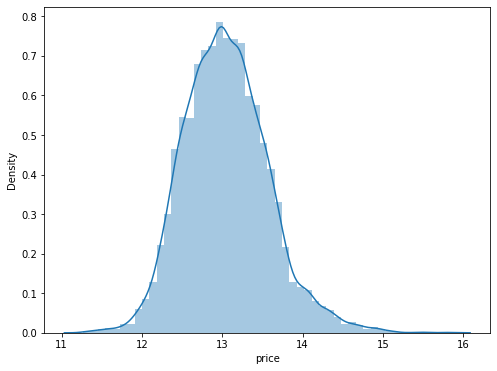

In [9]:
try:
    # 타겟 값의 정규화

    y = df_train['price']                                # 학습에 사용할 y
    df2_train = df_train.copy()                          # 혹시 몰라 df2 로 복사
    df_train = df_train.drop('price', axis=1)            # price 칼럼 제거
    y = np.log1p(y)                                      # y 로그 정규화

    df2_train['price'] = np.log1p(df2_train['price'])    # df2도 로그 정규화

    print('ok')
    
except:
    pass

# histogram을 그려봅니다.
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df2_train['price'])

다른 값들도 정규화 하겠습니다. 정규화 이후 모델의 RMSE를 구해봅니다.

In [10]:
# feature 정규화

skew_columns = ['bedrooms','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15','sqft_lot15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

get_scores(models, df_train, y)

,RMSE
XGBRegressor,127639.529428
LGBMRegressor,118729.515834


오~ 11만이 얼마 남지 않았네요!!  

라고 생각했지만 이정도 고생을 할 줄은 상상도 못한....  눈물 좀 닦고 이어갑니다.

## 우선 부동산 가격에 대한 고민에서 출발해 보겠습니다.

가격은 가치의 함수입니다.  
부동산의 가치는 땅의 가치와 건물의 가치의 합입니다.  
땅의 가치는 부동산의 위치에 영향을 받습니다.  
건물의 가치는 건물의 상태, 형태에 영향을 받습니다.  
물론 땅과 건물은 크기에 영향을 받습니다.  
  
따라서, 부동산의 가격은 땅의 위치와 크기, 건물의 상태, 형태와 크기의 함수입니다.
  
여기에 시간의 흐름에 따라 화폐가치가 변하기 때문에 시간도 고려 대상입니다.  

정리하면, 부동산의 가격은 다음 세 가지의 조합에의해 결정됩니다.  


1. 땅의 가치 = f(위치, 크기)
2. 건물의 가치 = g(상태, 형태, 크기)
3. 시간에 따른 화폐가치의 변화

## 1. 땅의 가치 = f(위치, 크기)  
  
땅의 가치에 영향을 미치는 요소는 위치와 크기입니다.  
따라서, 우리의 데이터 셋에서 위치와 크기를 알수 있는 컬럼을 선택하고 이들의 조합을 살펴봐야 합니다.  
  
'sqft_lot'   : 땅의 크기  
'sqft_lot15' : 땅의 크기, 위치 (주변 땅의 크기이므로)  
'waterfront' : 땅의 위치  
'view'       : 땅의 위치  
'zipcode'    : 땅의 위치  
'lat', 'long' : 땅의 위치  

### 가격나누기 : 땅과 건물의 가격을 구분하기  
  
땅과 건물의 가격을 구분해 보겠습니다.  
이는 가치를 얻기 위한 고육책입니다.  
우선, 땅과 건물의 가격은 그 크기에 비례해 구분된다고 가정하겠습니다.  


In [12]:
# 땅과 건물의 가격 구분 (땅의 면적 비율을 이용)
lot_ratio = df_train['sqft_lot']/(df_train['sqft_living']+df_train['sqft_lot'])   # 부동산 중 땅의 면적 비율
y_lot = lot_ratio*y                                      # 땅의 가격
y_living = (1-lot_ratio)*y                               # 건물 가격

# 단위가격 
y_unit_lot = y_lot/df_train['sqft_lot']        # 땅의 단위가격 (면적당 땅의 가격)

### 위치(long, lat)에 따른 가격 분포  
  
경도와 위도를 이용해 위치에 따른 땅의 단위가격을 그려보겠습니다.

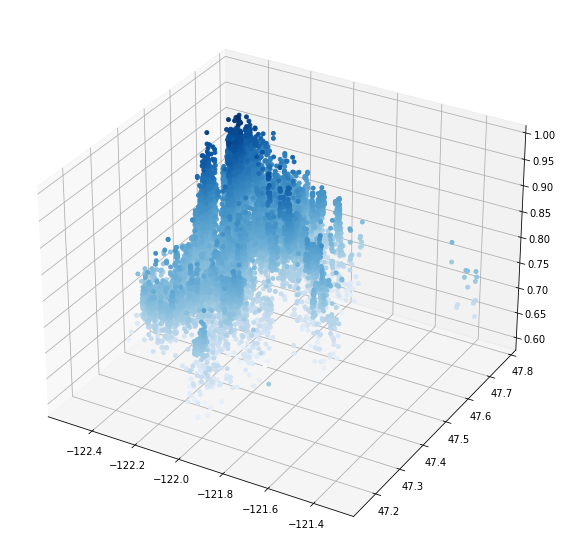

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train['long'], 
           df_train['lat'], 
           y_unit_lot, 
           alpha=1,
           c= y_unit_lot,                     # marker color
           marker='o', s=15, cmap='Blues')

plt.show()


  위 그래프를 보면 어떤 중심점으로부터 멀어질수록 가격이 낮아지는 경향을 볼 수 있습니다.  
  단위가격이 가장 높은 중심점을 찾아 보겠습니다.  
    
### 단위가격의 중심점 찾기  

In [14]:
# 최대값 위치
price_idxmax = y_unit_lot.idxmax()

location_price_max = [df_train.loc[price_idxmax,'long'],df_train.loc[price_idxmax,'lat']]

### 중심점으로부터 거리 구하기  
  
  경도와 위도를 이용해 중심점에서 각 점까지의 거리를 구해보겠습니다.  
  이를 이용해 경도와 위도에 따른 땅과 건물 가치의 비율을 결정할 예정입니다.
  

In [16]:
# 중심점으로부터의 거리 
for df in [df_train,df_test]:    # 트레인과 테스트를 한번에 바꿔주기
    df['distance'] = np.sqrt((df['long']-location_price_max[0])**2+ (df['lat']- location_price_max[1])**2 )

# get_scores(models, df_train, y)

,RMSE
LGBMRegressor,119038.700340
XGBRegressor,118938.293359


### 땅의 가치와 건물의 가치 비율 다시 정하기  
  
  일단 아이디어는 '중심에서 멀어지면 땅은 덜 중요해질 것이다'입니다.  
  이 아이디어를 표현해 보겠습니다.

corr_coef of price_lot and price = 0.2694


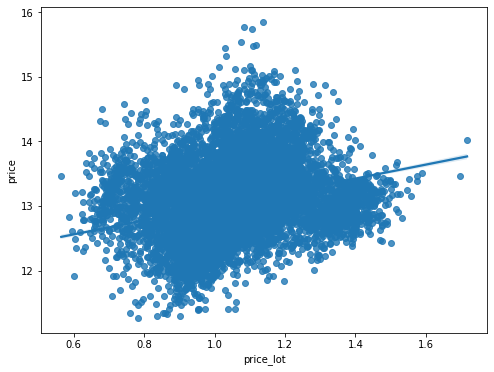

In [18]:
# 거리의 최대값 찾기
distance_max = df_train['distance'].max()     # 0 ~1.03

# 하이퍼 파라메터 #1
hp_1 = 3

# 땅의 가치 비율
lot_ratio = distance_max*df_train['sqft_lot']/(hp_1*distance_max*df_train['sqft_living']+distance_max*df_train['sqft_lot'])
y_lot = lot_ratio*y                                      # 땅의 기치
y_living = (1-lot_ratio)*y                               # 건물 가치

# 땅의 단위가격을 변수에 담기
df_train['price_lot'] = y_living/df_train['sqft_lot']        # 땅의 단위가격 (면적당 땅의 가격)

corr_plot('price_lot','price')

### 땅의 가치 보정_1. zipcode  
  
  zipcode는 우편번호입니다. 이는 서울로 따지면 동을 나타냅니다.  
  삼성동과 은평동의 땅 가치가 다르듯 zipcode가 다르면 다른 가치를 갖습니다.  
  이를 표현해 보겠습니다.

corr_coef of zipgb_lot and price = 0.3606


,RMSE
XGBRegressor,124885.729206
LGBMRegressor,120974.526385


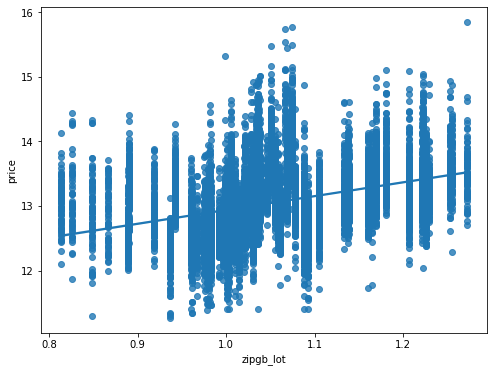

In [19]:
# zipcode로 groopby 후 평균을 내림차순으로 정렬
zip_gb = df_train.groupby('zipcode')['price_lot'].mean().sort_values(ascending = True)

# zip_gb을 이용해 땅의 가치 보정값을 'zipgb_lot'에 담기
i=0
for zc in zip_gb.index:
    for df in [df_train,df_test]:
        df.loc[df['zipcode']==zc, 'zipgb_lot'] = zip_gb.values[i]
    i += 1

df_train = df_train.drop('price_lot', axis=1)           # price 지우기; price는 test 셋에 없으므로 포함돼서는 안됨.

corr_plot('zipgb_lot','price')
# get_scores(models, df_train, y)

corr_coef of value_lot and price = -0.2445


,RMSE
XGBRegressor,123440.220619
LGBMRegressor,118073.378782


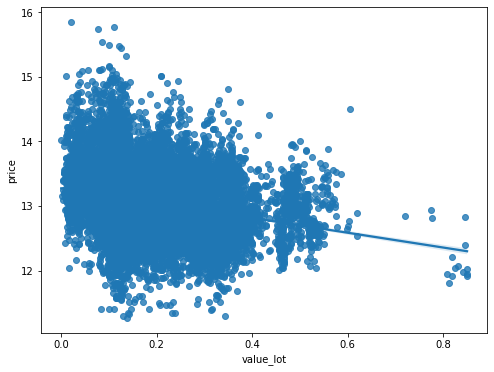

In [20]:
# 보정값 변수에 담기 

for df in [df_train,df_test]:
    df['value_lot'] = df['zipgb_lot']*df['distance']

corr_plot('value_lot','price')
# get_scores(models, df_train, y)

### 땅의 가치 보정_2. waterfront, view  
  
  waterfront나 view는 조망권을 나타냅니다.  
  이는 땅의 위치에 따라 결정되는 값으로 이 값이 높으면 땅의 가치가 커질 것입니다.  
  다만, 이 값을 더해 주는 것보다는 곱해주는 것이 의미있을 것입니다.  
  이를 표현해 보겠습니다.

corr_coef of view2 and price = -0.0546


,RMSE
XGBRegressor,121957.311198
LGBMRegressor,120470.133270


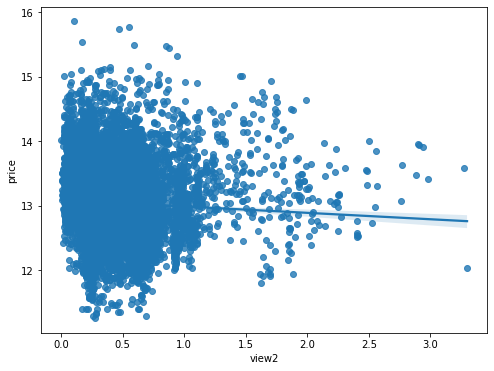

In [21]:
# 하이퍼 파라메터 #2
hp_2 = 2

for df in [df_train,df_test]:
    df['view2'] = ((df['waterfront']) + df['view'] + hp_2)*df['value_lot']

corr_plot('view2','price')
# get_scores(models, df_train, y)

## 

## 2. 건물의 가치 = f(상태, 형태, 크기)  
  
건물의 가치에 영향을 주는 것은 상태, 형태, 그리고 크기입니다.  
따라서, 우리의 데이터 셋에서 상태와 형태, 크기를 알수 있는 컬럼을 선택하고 이들의 조합을 살펴봐야 합니다.  
  
'bedrooms'       : 건물의 형태  
'bathrooms'      : 건물의 형태  
'floors'         : 건물의 형태  
'sqft_living'    : 건물의 크기  
'sqft_above'     : 건물의 크기  
'aqft_basement'  : 건물의 크기  
'sqft_living15'  : 건물의 크기  
'condition'      : 건물의 상태  
'grade'          : 건물의 상태  
'yr_bilt'        : 건물의 상태  
'yr_renovated'   : 건물의 상태


### 건물의 형태, 크기_1. 침실/화장실  
  
  건물의 형태를 나타내는 변수는 침실의 수, 화장실 수, 층 수입니다.  
  건물의 크기에는 연면적, 단면적, 지하실 면적, 이웃의 건물면적이 있습니다.  
    
  형태와 크기는 사실 밀접한 관련이 있습니다.  
  이 중 침실과 화장실은 그 개수보다는 크기가 중요할 수 있습니다. 
  한번 알아보겠습니다.
  

-3.1735118593887184 19.768786341944704
-2.378929677505623 20.6333116396585
corr_coef of bedbath_unit and price = -0.4362


,RMSE
XGBRegressor,122457.400936
LGBMRegressor,118902.749503


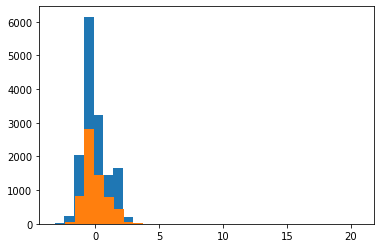

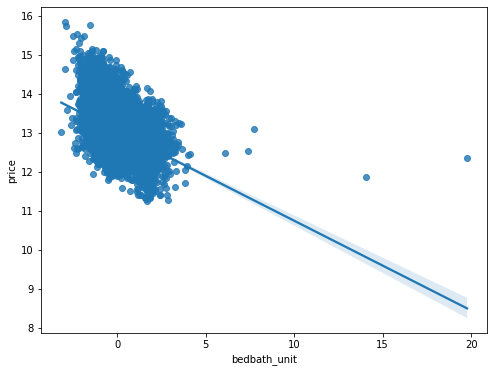

In [22]:
for df in [df_train,df_test]:

    # 침실과 화장실의 단위 크기
    bedbath_unit = df['sqft_above']/(df['bedrooms']+df['bathrooms']+1)
    
    # 정규화
    bedbath_unit = zs_normal(bedbath_unit)
    plt.hist(bedbath_unit, bins=30)

    # nin, max
    min_ = min(bedbath_unit)
    max_ = max(bedbath_unit)
    print(min_, max_)
    
    # 변수에 담기
    df['bedbath_unit'] = bedbath_unit
    
corr_plot('bedbath_unit','price')
# get_scores(models, df_train, y)

너무 큰 예외 값이 존재합니다. 제거하겠습니다.

In [ ]:
# for df in [df_train]:
#     # 표준편차
#     sigma = np.std(df['bedbath_unit'])
    
#     # 4 sigma 이외인 행 삭제하기
#     index = df[df['bedbath_unit'] > 4*sigma].index
#     df.drop(index,axis='index',inplace=True)
#     y.drop(index,axis='index',inplace=True)
#     df2_train.drop(index,axis='index',inplace=True)
    
#     # 확인
#     plt.hist(df['bedbath_unit'], bins=30)

# get_scores(models, df_train, y)

### 건물의 형태, 크기_2. 층수와 지하실
  
  지하실은 단순히 넓은 것 보다는 건물의 단면적 대비 넓이 비율이 더 큰 의미가 있을 것입니다.  
  한번 알아보겠습니다.
  

,RMSE
XGBRegressor,123710.706539
LGBMRegressor,120305.785238


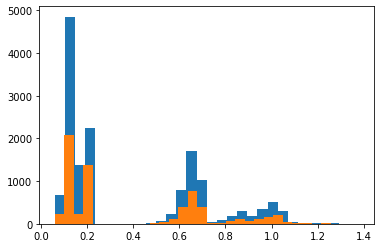

In [24]:
for df in [df_train,df_test]:
    temp=pd.DataFrame()
    # 건물의 단면적 ; 지상면적/층수
    temp['area_1f'] = df['sqft_above']/df['floors']
    
    # 지하실의 크기비율
    df['base_ratio'] = df['sqft_basement']/temp['area_1f']
#     plt.hist(base_ratio, bins=30)                     # 지하실이 없는 경우가 많음. 지하실이 없다고 가치가 없는 것은 아니므로
                                                      # 이경우 area_1f로 하되 패널티를 줌
    # 하이퍼 파라메터 #4
    hp_4 = 0.03
    
    # 0인 경우 처리
    df.loc[df['base_ratio']==0,'base_ratio'] = hp_4*temp['area_1f']

    # 확인
#     plt.hist(df['base_ratio'], bins=30)
    
    # log 정규화
    df['base_ratio'] = np.log1p(df['base_ratio'])    
    plt.hist(df['base_ratio'], bins=30)

# get_scores(models, df_train, y)

### 건물의 상태_리모델링/등급
  
  리모델링은 집의 상태를 개선합니다.  
  따라서, 리모델링 한 건물은 최초 지어진 것과 다른 모습일 것입니다.  
  만약 리모델링이 진행됐다면 최조 지어진 연도는 큰 의미가 없습니다.
  

,RMSE
XGBRegressor,122338.740558
LGBMRegressor,119132.945731


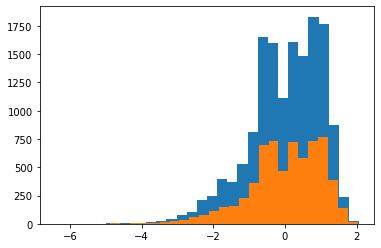

In [25]:
for df in [df_train,df_test]:
    # 리모델링 연도에서 건축연도 빼보기
    yr_diff = df['yr_renovated']-df['yr_built']
#     plt.hist(yr_diff, bins=30)                     # 리모델링이 없는 부동산은 값 차이가 너무 큼
    
    # 리모델링 된 경우 리모델링 날짜로 건축년도 바꿔주기
    df['yr_used'] = 0
    df.loc[df['yr_renovated']!=0,'yr_used'] = df['yr_renovated']
    df.loc[df['yr_renovated']==0,'yr_used'] = df['yr_built']
    
    # 정규화 하고 등급과 컨디션, 면적 곱하기
    df['yr_used'] = zs_normal(df['yr_used'])*df['grade']*df['condition']*df['sqft_living']
    
    # 다시 정규화
    df['yr_used'] = zs_normal(df['yr_used'])
    plt.hist(df['yr_used'], bins=30)
    
# corr_plot('yr_used','price')
# get_scores(models, df_train, y)

## 3. 시간의 변화 = h(화폐가치 변화)  
  
건물의 가격은 시간에 따라 변합니다.   
이를 확인해 보겠습니다.


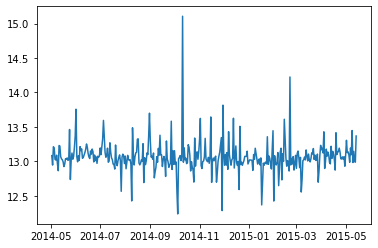

In [26]:
for df in [df2_train]:
    # 날짜로 pivot_table 만들기
    temp = pd.pivot_table(df,                
                         index = 'date',    # 행 위치에 들어갈 열
                         values = 'price',     # 데이터로 사용할 열
                         aggfunc = 'mean')   # 데이터 집계함수


temp['date']=temp.index  
temp['date'] = pd.to_datetime(temp['date'], format="%Y%m%d")
temp.head()
plt.plot(temp['date'],temp['price'])

약간의 계절성을 띄긴 하지만 1년정도는 큰 변화가 없는 것으로 보입니다.

## Grid Search

In [27]:
param_grid = {
    'n_estimators': [100, 300,500],
    'max_depth': [10, 20, 50],
    'learning_rate': [0.1, 0.01]
}

# model = LGBMRegressor(random_state=random_state)
# model_lgb = my_GridSearch(model, df_train, y, param_grid, verbose=2, n_jobs=5)
# print(model_lgb)

# model_xgb = XGBRegressor(random_state=random_state)
# model_xgb = my_GridSearch(model_xgb, df_train, y, param_grid, verbose=2, n_jobs=5)
# print(model_xgb)

In [29]:
# model.get_params()
# print(model_lgb)            # learning_rate=0.1, max_depth=10, n_estimators=300
# print(model_xgb)

## Average Blending

In [30]:
# LGBMRegressor와 XGBRegressor의 블렌딩

# LGBMRegressor
model_lgb = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=random_state)
model_lgb.fit(df_train, y)
y_pred_lgbm = model_lgb.predict(df_test)
y_pred_lgbm_ck = model_lgb.predict(df_train)

# XGBRegressor
model_xgb = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=random_state)
model_xgb.fit(df_train, y)
y_pred_xgbm = model_xgb.predict(df_test)
y_pred_xgbm_ck = model_xgb.predict(df_train)

# prediction = y_pred_xgbm
# prediction_ck = y_pred_xgbm_ck

# blending
prediction = (y_pred_lgbm+y_pred_xgbm)/2
prediction_ck = (y_pred_lgbm_ck+y_pred_xgbm_ck)/2

# check!
print(rmse(y,y_pred_lgbm_ck))
print(rmse(y,y_pred_xgbm_ck))

print(rmse(y,prediction_ck))

64806.72521657433
17456.202287587937
39785.260815630114


In [ ]:
# df_train
'''
64912.77713159462
56912.92928903646
58289.408408628784'''

In [31]:
prediction

array([13.07889545, 13.09316869, 14.08290115, ..., 13.08992041,
       12.73617122, 12.98007204])

## 제출하기

In [32]:
# scale 변환
prediction = np.expm1(prediction)

# summission 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

#예측값 기록하기
submission['price'] = prediction
submission.head()

# 저장하기
submission_csv_path = '{}/submission_{}.csv'.format(data_dir,'0922_2201')
submission.to_csv(submission_csv_path, index=False)

print('ok')

ok


In [ ]:
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
# submission_path = join(data_dir, 'submission_','0922_2201.csv')
# submission1 = pd.read_csv(submission_path)

# submission1.head()